# Import Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from tensorflow.keras.datasets import mnist
from scipy.ndimage import interpolation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Data Preparation

## Import Data

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path='mnist.npz')

## Deskewing

Handwritten images representing the same digit can variate considerably visually, possibly appearing crooked, inclined, misaligned, slanted and/or skewed. Computers, unlike humans, fail to capture easily similarities between image transformations.

To faciliate the algorithm task, we model the image deskewing as an affine transformation. We assume that the handwritten image is in reality some affine transformation on the original unknown image. We can write this as follows:  

$Image'=A(Image)+b$, where $Image'$ is the handwritten image, $Image$ is the original unknow image, A represents the linear map, and b represents the translation.

We know need to know:
 - The center of mass of the image in order to offset it accordingly.
 - The skew of the angle, approximated by the lower triangular correlation matrix of the pixel intensities.

The function _moments_ below returns the first moments for both image dimensions and the correlation matrix.

The offset is computed as: $\mu - AC$, where $C$ is the center of the handwritten image.

### Define Moment Function

In [3]:
def moments(image):
    shp0, shp1 = np.mgrid[:image.shape[0],:image.shape[1]] 
    n_pixels = np.sum(image)
    m1_x = np.sum(shp0*image)/n_pixels 
    m1_y = np.sum(shp1*image)/n_pixels 
    m2_x = np.sum((shp0-m1_x)**2*image)/n_pixels 
    m2_y = np.sum((shp1-m1_y)**2*image)/n_pixels 
    cov = np.sum((shp0-m1_x)*(shp1-m1_y)*image)/n_pixels
    mu_vector = np.array([m1_x,m1_y]) 
    correlation_matrix = np.array([[m2_x/m2_x, 0],[cov/m2_x, m2_y/m2_y]])
    return mu_vector, correlation_matrix

### Define Deskewing-Scaling Function

In [4]:
def deskew_scale(image):
    mu_v, corr_m = moments(image)
    affine = corr_m
    ocenter = np.array(image.shape)/2.0
    offset = mu_v-np.dot(affine, ocenter)
    img = interpolation.affine_transform(image, affine, offset = offset)
    return (img - img.min()) / (img.max() - img.min())

### Exempli Gratia

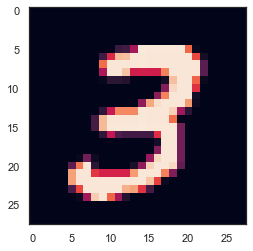

In [5]:
plt.imshow(X_train[7]);

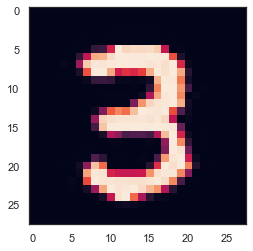

In [6]:
plt.imshow(deskew_scale(X_train[7]));

### Deskewed and Rescaled Image Generation

In [7]:
tmp_train = np.zeros((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))

for i in range(X_train.shape[0]):
    tmp_train[i] = deskew_scale(X_train[i]).flatten()

X_train = tmp_train

In [8]:
tmp_test = np.zeros((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

for i in range(X_test.shape[0]):
    tmp_test[i] = deskew_scale(X_test[i]).flatten()
    
X_test = tmp_test

## Class Balance

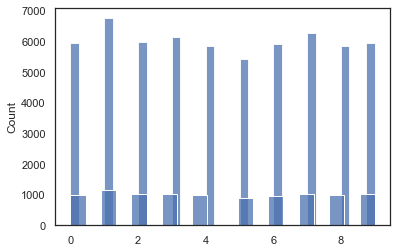

In [9]:
sns.histplot(Y_train), sns.histplot(Y_test);

# SVM Model

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.30, random_state=1)

In [11]:
def n_component_analysis(n, X_train, Y_train, X_val, Y_val, kernel_type="linear"):
   
    pca = PCA(n_components=n)
    print("PCA begin with variance explained: {}".format(n))
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)

    print('SVC begin')
    clf1 = SVC(kernel = kernel_type)
    clf1.fit(X_train_pca, Y_train)
    predictions = clf1.predict(X_val_pca)
    accuracy = metrics.accuracy_score(Y_val, predictions)
    
    print("Accuracy: {}".format(accuracy))
    return accuracy

In [14]:
n_s = np.linspace(0.85, 0.95, num=10)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n, X_train, Y_train, X_val, Y_val, "rbf")
    accuracy.append(tmp)

PCA begin with variance explained: 0.85
SVC begin
Accuracy: 0.9849444444444444
PCA begin with variance explained: 0.861111111111111
SVC begin
Accuracy: 0.9852222222222222
PCA begin with variance explained: 0.8722222222222222
SVC begin
Accuracy: 0.9855555555555555
PCA begin with variance explained: 0.8833333333333333
SVC begin
Accuracy: 0.9857777777777778
PCA begin with variance explained: 0.8944444444444444
SVC begin
Accuracy: 0.9859444444444444
PCA begin with variance explained: 0.9055555555555556
SVC begin
Accuracy: 0.986
PCA begin with variance explained: 0.9166666666666666
SVC begin
Accuracy: 0.986
PCA begin with variance explained: 0.9277777777777777
SVC begin
Accuracy: 0.9857777777777778
PCA begin with variance explained: 0.9388888888888889
SVC begin
Accuracy: 0.9856666666666667
PCA begin with variance explained: 0.95
SVC begin
Accuracy: 0.9858888888888889


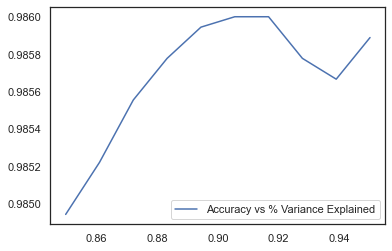

In [15]:
plt.figure()
plt.plot(n_s, np.array(accuracy), label='Accuracy vs % Variance Explained')
plt.legend()
plt.show()

In [16]:
pca = PCA(n_components=0.91)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

clf1 = SVC(kernel="rbf", C=20, gamma=0.01)
clf1.fit(X_train_pca, Y_train)
predictions=clf1.predict(X_val_pca)
metrics.accuracy_score(Y_val, predictions)

0.9867222222222222

In [17]:
results = clf1.predict(pca.transform(X_test))
accuracy = metrics.accuracy_score(Y_test, results)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.9876
